<a href="https://colab.research.google.com/github/robert-altdeep/causalML/blob/update-transportation-example/Building_and_doing_Inference_on_Transportation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import BeliefPropagation
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt


**Step 1**: Build the transportation model.

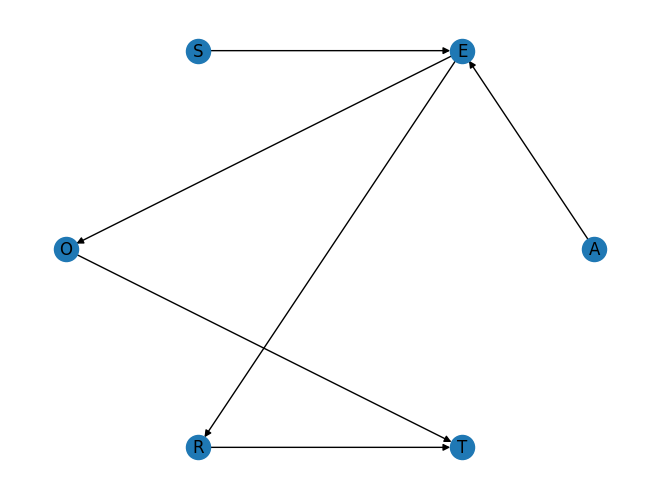

In [11]:
model = BayesianModel(
    [
        ('A', 'E'),
        ('S', 'E'),
        ('E', 'O'),
        ('E', 'R'),
        ('O', 'T'),
        ('R', 'T')
    ]
)
pos = nx.circular_layout(model)
nx.draw(model, with_labels=True, pos=pos)
plt.show()

## Step 2: Train a causal graphical model on the causal DAG.

We can train a causal graphica model on a causal DAG structure.  In this case we'll download training data and train the parameters of the conditional probability distribution of each node give its parents in the DAG.  The training data looks as follows.

In [12]:
survey_url = "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv"
data = pd.read_csv(survey_url)
print(data)

         A  S     E    O      R      T
0    adult  F  high  emp  small  train
1    young  M  high  emp    big    car
2    adult  M   uni  emp    big  other
3      old  F   uni  emp    big    car
4    young  F   uni  emp    big    car
..     ... ..   ...  ...    ...    ...
495  young  M  high  emp    big  other
496  adult  M  high  emp    big    car
497  young  M  high  emp  small  train
498  young  M  high  emp  small    car
499  adult  M  high  emp  small  other

[500 rows x 6 columns]


All of the variables are categorical.  So we'll use conditional probability tables to represent the conditional probability distributions.  We'll use the date to fit the parameters of these tables.

We fit using `BayesianEstimator`, which uses Bayesian estimation of each parameter using the [Dirichlet conjugate prior](https://en.wikipedia.org/wiki/Dirichlet_distribution#Conjugate_prior_of_the_Dirichlet_distribution).  If you are unfamiliar with the technique, you can think of it as [an additive smoothing approach](https://en.wikipedia.org/wiki/Additive_smoothing) that prevents us from getting parameter estimates of 0 or 1 in cases where the data is sparse.  The default estimation method for the `model.fit` method is [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).  Note that the weight learning/parameter fitting technique is purely a statistical/computation concern, it has nothing to do with the causal elements of the analysis.

In [13]:

model.fit(data, estimator=BayesianEstimator)

# Print out CPD for variable "O"
print(model.get_cpds()[3])

+---------+----------------------+----------------------+
| E       | E(high)              | E(uni)               |
+---------+----------------------+----------------------+
| O(emp)  | 0.9786324786324786   | 0.9705882352941176   |
+---------+----------------------+----------------------+
| O(self) | 0.021367521367521368 | 0.029411764705882353 |
+---------+----------------------+----------------------+


In canonical ways of learning about causal inference, students have to learn various statistical inference techniques for various types of causal analysis.

Yet a distinctive trend in machine learning is the commodification of training and inference.  A great example is the probabilistic graphical modeling software comes with probabilistic inference algorithms that will generally work without any user input once we've specified the model.  If we implement a causal graphical model, we can use these algorithms for causal inference.

Two prime examples of such algorithms are [variable elimination](https://en.wikipedia.org/wiki/Variable_elimination) and [belief propagation](https://en.wikipedia.org/wiki/Belief_propagation).  

In [14]:
inference = VariableElimination(model)
query_result = inference.query(['R'], evidence={'T': 'train'})
print(query_result)

+----------+----------+
| R        |   phi(R) |
+==========+==========+
| R(big)   |   0.6787 |
+----------+----------+
| R(small) |   0.3213 |
+----------+----------+


/Users/jprusso/github/causalML/.venv/lib/python3.9/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [15]:
inference = BeliefPropagation(model)
query_result = inference.query(['A'], evidence={'T': 'train'})
print(query_result)

+----------+----------+
| A        |   phi(A) |
+==========+==========+
| A(adult) |   0.3921 |
+----------+----------+
| A(old)   |   0.1481 |
+----------+----------+
| A(young) |   0.4598 |
+----------+----------+


To learn more about inference with graphical models, view [part 2 of Daphne Koller's course on graphical models](https://www.coursera.org/learn/probabilistic-graphical-models-2-inference).

We can also implement causal models in modern probabilistic programming languages, which are more flexible that probabilistic graphical models.  Some of these languages implement cutting-edge inference algorithms that make use of deep learning technology, such as [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) and [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods).